# NAMAC: AQN policy evaluation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import scipy.stats as stats
from scipy.stats import (find_repeats, distributions)

## Modified "scipy.wilcoxon" to return (Z, p)
def wilcoxon(x, y=None, zero_method="wilcox", correction=False,
             alternative="two-sided"):

    if zero_method not in ["wilcox", "pratt", "zsplit"]:
        raise ValueError("Zero method should be either 'wilcox' "
                         "or 'pratt' or 'zsplit'")

    if alternative not in ["two-sided", "less", "greater"]:
        raise ValueError("Alternative must be either 'two-sided', "
                         "'greater' or 'less'")

    if y is None:
        d = asarray(x)
        if d.ndim > 1:
            raise ValueError('Sample x must be one-dimensional.')
    else:
        x, y = map(np.asarray, (x, y))
        if x.ndim > 1 or y.ndim > 1:
            raise ValueError('Samples x and y must be one-dimensional.')
        if len(x) != len(y):
            raise ValueError('The samples x and y must have the same length.')
        d = x - y

    if zero_method in ["wilcox", "pratt"]:
        n_zero = np.sum(d == 0, axis=0)
        if n_zero == len(d):
            raise ValueError("zero_method 'wilcox' and 'pratt' do not work if "
                             "the x - y is zero for all elements.")

    if zero_method == "wilcox":
        # Keep all non-zero differences
        d =  np.compress(np.not_equal(d, 0), d, axis=-1)

    count = len(d)
    if count < 10:
        warnings.warn("Sample size too small for normal approximation.")

    r = stats.rankdata(abs(d))
    r_plus = np.sum((d > 0) * r, axis=0)
    r_minus = np.sum((d < 0) * r, axis=0)

    if zero_method == "zsplit":
        r_zero = np.sum((d == 0) * r, axis=0)
        r_plus += r_zero / 2.
        r_minus += r_zero / 2.

    # return min for two-sided test, but r_plus for one-sided test
    # the literature is not consistent here
    # r_plus is more informative since r_plus + r_minus = count*(count+1)/2,
    # i.e. the sum of the ranks, so r_minus and the min can be inferred
    # (If alternative='pratt', r_plus + r_minus = count*(count+1)/2 - r_zero.)
    # [3] uses the r_plus for the one-sided test, keep min for two-sided test
    # to keep backwards compatibility
    if alternative == "two-sided":
        T = min(r_plus, r_minus)
    else:
        T = r_plus
    mn = count * (count + 1.) * 0.25
    se = count * (count + 1.) * (2. * count + 1.)

    if zero_method == "pratt":
        r = r[d != 0]
        # normal approximation needs to be adjusted, see Cureton (1967)
        mn -= n_zero * (n_zero + 1.) * 0.25
        se -= n_zero * (n_zero + 1.) * (2. * n_zero + 1.)

    replist, repnum = stats.find_repeats(r)
    if repnum.size != 0:
        # Correction for repeated elements.
        se -= 0.5 * (repnum * (repnum * repnum - 1)).sum()

    se = np.sqrt(se / 24) 

    # apply continuity correction if applicable
    d = 0
    if correction:
        if alternative == "two-sided":
            d = 0.5 * np.sign(T - mn)
        elif alternative == "less":
            d = -0.5
        else:
            d = 0.5

    # compute statistic and p-value using normal approximation
    z = (T - mn - d) / se
    if alternative == "two-sided":
        prob = 2. * distributions.norm.sf(abs(z))
    elif alternative == "greater":
        # large T = r_plus indicates x is greater than y; i.e.
        # accept alternative in that case and return small p-value (sf)
        prob = distributions.norm.sf(z)
    else:
        prob = distributions.norm.cdf(z)

    return np.round(z,2), np.round(prob,3)


### Load the test data

In [2]:
# Load baselines: RQN and TQN
def getBaseResult( model, iterations): #(evalPath, method, model, iterations):
    df = pd.DataFrame(columns=['iteration'])
    df.iteration = iterations
    tmp = df.copy(deep=True)
    
    # Load results of single agents
    for f in range(0,10):
        df[model+str(f)] =load(model, f)
    
    #tmp = adf[['iteration']].copy(deep=True)
    tmp['S_'+model] = df[df.columns[1:]].mean(axis = 1)
    tmp['S_'+model+'_std'] = df[df.columns[1:]].std(axis=1)
    
    return tmp, df

def load(model, fold):
    path = 'eval/Q1/{}/'.format(model)
    sdf = pd.read_csv(path+'eval_q1_{}_fold{}.csv'.format(model, str(fold)), header=0)
    
    if model=='TQN' or model == 'T_Discount':
        sdf = sdf[sdf.method=='TQN_elap']
    elif model== 'RQN':
        sdf = sdf[sdf.method=='RQN_elap']
    elif model == 'DQN':
        sdf = sdf[sdf.method=='DQN_elap']

    sdf = sdf[sdf.iteration.isin([1] + [100000*(i+1) for i in range(20)])]

    return sdf.loc[:,'avgUtil'].values


# Load data: AQN_P (Predictive Q-Average)
def getT_Data(evalPath, iterations, predT, fNum):
    ddf = pd.DataFrame(columns = ['iteration'])
    ddf.iteration = iterations
    for m in ['RQN', 'TQN']: 
        modelList = []
        if m == 'RQN':
            methodName = 'AQNp'
        else:
            methodName = 'TAQNp'
            
        filename = evalPath+m+'/eval_P'+str(predT)+'_q1_elapA_'+m+'_avg_fold'    
        for f in range(fNum):
            df = pd.read_csv(filename+'{}.csv'.format(str(f)), header=0)
            #print(f, df.avgUtil.values)
            ddf['P'+m+str(f)+'t'] = df.avgUtil.values
            modelList += ['P'+m+str(f)+'t']
        ddf[methodName] = ddf[modelList].mean(axis=1)
        ddf[methodName+'_std'] = ddf[modelList].std(axis=1)
    return ddf


# Load data: AQN_C (Concurrent Q-Average)
def getConcurQData(iterations, maNum):
    ddf = pd.DataFrame(columns = ['iteration'])
    ddf.iteration = iterations
    for m in ['RQN', 'TQN']: 
        if m == 'RQN':
            method = 'AQNc'+str(maNum)
        else:
            method = 'TAQNc'+str(maNum)
        polNames = [method+'_'+str(i) for i in range(10)]

        for f in range(10):
            df = pd.read_csv('eval/Q1/AQN_C/M'+str(maNum)+'/'+m+'/eval_q1_elapA_'+m+'_avg_fold'+\
                             str(f)+'.csv', header=0)
            #print(m, f, len(df))
            ddf[method+'_'+str(f)] = df.avgUtil.values

        ddf[method] = ddf[polNames].mean(axis=1)
        ddf[method+'_std'] = ddf[polNames].std(axis=1)
    return ddf


# Load data: AQN (AQN_P + AQN_C)
def getTM_Data(iterations, fNum, maNum, predT):

    ddf = pd.DataFrame(columns = ['iteration'])
    ddf.iteration = iterations
    
    for m in ['RQN', 'TQN']:
        if m == 'RQN':
            methodName = 'AQNc'+str(maNum)+'p'+str(predT)
        else:
            methodName = 'TAQNc'+str(maNum)+'p'+str(predT)
        modelList = []
        
        for f in range(fNum): #eval_M2_T90_q1_elapA_TQN_avg_fold0
            df = pd.read_csv('eval/Q1/AQN/'+m+'/eval_M'+str(maNum)+'_T'+str(predT)+'_q1_elapA_'+m+\
                                 '_avg_fold'+str(f)+'.csv', header=0)
            ddf[m+str(f)] = df.avgUtil.values
            modelList += [m+str(f)]
        ddf[methodName] = ddf[modelList].mean(axis=1)
        ddf[methodName+'_std'] = ddf[modelList].std(axis=1)
    return ddf


def getCI(model):
    CI_low = np.round(np.mean(model)-1.96*np.std(model)/np.sqrt(60), 2)
    CI_up = np.round(np.mean(model)+1.96*np.std(model)/np.sqrt(60), 2)
    return CI_low, CI_up 

def getMax(df):
    print("{:.2f}".format(df[df.columns[1:]].max().max()))

### Figures

In [3]:
def showAll(df,title, methods, filename, shade, legendPos, legendSize, ncol, dpi, legendLoc= (1.01, 0.1)):
    lw = 2
    ms=8

    ite = df.iteration        

    fig, ax = plt.subplots(figsize=(10,7))

    for i in range(len(methods)):
        ax.plot(ite, df[methods[i]], label=methods[i], marker=markers[i],markevery=1, markersize=7, linestyle=line_style[i],\
                color=colors[i], lw=lw)
        if shade:
            ax.fill_between(df.loc[:, 'iteration'], df.loc[:, methods[i]+'_lCI'], \
                            df.loc[:, methods[i]+'_uCI'], color = colors[i], alpha = 0.08)


    box = ax.get_position()
    ax.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])

    plt.legend(fontsize=legendSize, frameon=False)
        
    plt.xticks(np.arange(min(ite), max(ite)+10, 500000))
    if ytickMin > 0:
        plt.yticks(np.arange(ytickMin, ytickMax, 2))

    xlabels = ['{:.0f}'.format(x) + 'K' for x in ax.get_xticks()/1000] #'{:,.0f}'
    ax.set_xticklabels(xlabels)

    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.ylabel('Utility', fontsize=22) #, fontweight='bold'
    plt.xlabel('Training iteration', fontsize=22)
    plt.title(title, fontsize=22)
    if filename != '':
        plt.savefig('eval/fig/'+filename+'.png', bbox_inches='tight', format='png', dpi=dpi)

        
def getCIall(df, modelNames, repetition):
    CI_df = pd.DataFrame(columns = ['iteration'])
    for m in modelNames:
        df[m+'_lCI'] = df[m].values - 1.96 * df[m+'_std'].values/np.sqrt(repetition) # 95% = 1.96 / 90% = 1.645
        df[m+'_uCI'] = df[m].values + 1.96 * df[m+'_std'].values/np.sqrt(repetition)
    return df

def getModelCI(dfList, modelNames):
    CI_df = pd.DataFrame(columns = ['timestep'])
    CI_df['timestep'] = dfList[0]['timestep']
    
    for i in range(len(modelNames)):
        CI_df[modelNames[i]] = dfList[i]['mean'] # modelNames[i]+'_mean'
        CI_df[modelNames[i]+'_lowCI'] = dfList[i]['mean'] - dfList[i]['ConfInv']        
        CI_df[modelNames[i]+'_upperCI'] =  dfList[i]['mean'] + dfList[i]['ConfInv']
    return CI_df


def getCIlist(feat):
    tmp = []
    for f in feat:
        tmp += [f+'_lCI', f+'_uCI']
    return tmp


## Table: Final Results

In [6]:
# Used [NAMAC final report]
# 1. Load result files

iterations = [1] + [100000*(i+1) for i in range(20)]
predTs = [30,60,120,'030','060','0120','0360','03120','06120']
maxR = 57.37

# RQN / TQN results
tmp, dqnAll = getBaseResult('DQN', iterations)
tmp, rqnAll = getBaseResult('RQN', iterations)
tmp, tqnAll = getBaseResult('TQN', iterations)
dqnAll['DQN'] = dqnAll[dqnAll.columns[1:11]].mean(axis=1)
dqnAll['DQN_std'] = dqnAll[dqnAll.columns[1:11]].std(axis=1)
rqnAll['RQN'] = rqnAll[rqnAll.columns[1:11]].mean(axis=1)
rqnAll['RQN_std'] = rqnAll[rqnAll.columns[1:11]].std(axis=1)
tqnAll['TQN'] = tqnAll[tqnAll.columns[1:11]].mean(axis=1)
tqnAll['TQN_std'] = tqnAll[tqnAll.columns[1:11]].std(axis=1)

print("DQN max: {:.2f}".format(dqnAll[dqnAll.columns[1:]].max().max()))
print("RQN max: {:.2f}".format(rqnAll[rqnAll.columns[1:]].max().max()))
print("TQN max: {:.2f}".format(tqnAll[tqnAll.columns[1:]].max().max()))


# Predictive AQN (AQNp)
evalPath = 'eval/Q1/AQN_P/'
maxR = 0
maxIdx = 0
init = True
for p in predTs:
    pdf = getT_Data(evalPath, iterations, predT=p, fNum=10)
    if maxR < pdf[pdf.columns[1:]].max().max():
        maxR = pdf[pdf.columns[1:]].max().max()
        maxIdx = p
    if init:
        apdf2 =  pdf[['iteration']].copy(deep=True)
        init = False
    apdf2['AQNp'+str(p)] = pdf['AQNp'].values
    apdf2['AQNp'+str(p)+'_std'] = pdf['AQNp_std'].values
    apdf2['TAQNp'+str(p)] = pdf['TAQNp'].values
    apdf2['TAQNp'+str(p)+'_std'] = pdf['TAQNp_std'].values
print("AQNp max: {:.2f} ({})".format(maxR, maxIdx))

# Concurrent AQN (AQNc)
madf2 = getConcurQData(iterations, maNum=2)
madf3 = getConcurQData(iterations, maNum=3)
print("AQNc max: {:.2f}".format(np.max([madf2[madf2.columns[1:]].max().max(), 
                                        madf3[madf3.columns[1:]].max().max()])))
   
# AQN (AQNc2p2)
c2p30df2 = getTM_Data(iterations, fNum=10, maNum=2, predT='030')
c2p60df2 = getTM_Data(iterations, fNum=10, maNum=2, predT='060')
c2p120df2 = getTM_Data(iterations, fNum=10, maNum=2, predT='0120')
print("AQNc2p2 max: {:.2f}".format(np.max([c2p30df2[c2p30df2.columns[1:]].max().max(), 
                                        c2p60df2[c2p60df2.columns[1:]].max().max(), 
                                        c2p120df2[c2p120df2.columns[1:]].max().max()])))

# combine results
xdf2 = pd.concat([apdf2, dqnAll[['DQN', 'DQN_std']]], axis=1)
xdf2 = pd.concat([xdf2, rqnAll[['RQN', 'RQN_std']]], axis=1)
xdf2 = pd.concat([xdf2, tqnAll[['TQN', 'TQN_std']]], axis=1)
xdf2 = pd.concat([xdf2, madf2[['AQNc2', 'AQNc2_std', 'TAQNc2', 'TAQNc2_std']]], axis=1)
xdf2 = pd.concat([xdf2, madf3[['AQNc3', 'AQNc3_std', 'TAQNc3', 'TAQNc3_std']]], axis=1)
xdf2 = pd.concat([xdf2, c2p30df2[['AQNc2p030', 'AQNc2p030_std', 'TAQNc2p030', 'TAQNc2p030_std']]], axis=1)

final_methods = ['RQN','DQN','AQNp060','AQNc2', 'AQNc2p030',
                 'TQN', 'TAQNp0120','TAQNc2', 'TAQNc2p030']

iterCondition = 1500000
rqn_base = xdf2.loc[xdf2.iteration>iterCondition, 'RQN'].mean() # for calcuation of Improvement
maxR = 57.37
resTab = pd.DataFrame(columns = ['Model', 'Mean', 'SD', 'CI_low','CI_up', 'Wilcoxon_Z', 'Wilcoxon_p', 'Improvement']) 

for m in final_methods: 
    resTab.loc[len(resTab)] = [m, np.round(xdf2.loc[xdf2.iteration>iterCondition, m].mean(), 2), 
                              np.round(xdf2.loc[xdf2.iteration>iterCondition, m+'_std'].mean(), 2),'' ,'' , '','',
                              100+np.round((xdf2.loc[xdf2.iteration>iterCondition, m].mean()-rqn_base)/(maxR-rqn_base)*100,1)]
resTab.Model = ['RQN','DQN','AQNp2','AQNc2',  'AQNc2p2', 'TQN','TAQNp2','TAQNc2','TAQNc2p2']  


# =====================================================================
# 2. Confidence Intervals +  Wilconxon (Z, p)
p1r, p2r, p3r = [], [], []
p1t, p2t, p3t = [], [], []
c2t, c3t, c4t = [],[],[]
c2r, c3r, c4r = [],[],[]
dqnA, rqnA, tqnA = [], [], []
c2p2r, c2p2t = [], []
evalPath = 'eval/Q1/AQN_P/'
#evalPath, iterations, predT, fNum
pdf1_30 = getT_Data(evalPath,iterations, predT='30', fNum=10)
pdf1_120 = getT_Data(evalPath,iterations, predT='120', fNum=10)
pdf2_060 = getT_Data(evalPath, iterations, predT='060', fNum=10)
pdf2_0120 = getT_Data(evalPath, iterations, predT='0120', fNum=10)
pdf3_0360 = getT_Data(evalPath,iterations, predT='0360', fNum=10)

iterCon = 1500000
for i in range(10):
    p2r += pdf2_060.loc[pdf2_060.iteration>iterCon, 'PRQN'+str(i)+'t'].values.tolist()
    p2t += pdf2_0120.loc[pdf2_0120.iteration>iterCon, 'PTQN'+str(i)+'t'].values.tolist()
    dqnA += dqnAll.loc[dqnAll.iteration>iterCon, 'DQN'+str(i)].values.tolist()
    rqnA += rqnAll.loc[rqnAll.iteration>iterCon, 'RQN'+str(i)].values.tolist()
    tqnA += tqnAll.loc[tqnAll.iteration>iterCon, 'TQN'+str(i)].values.tolist()
    c2t += madf2.loc[madf2.iteration>iterCon, 'TAQNc2_'+str(i)].values.tolist()
    c2r += madf2.loc[madf2.iteration>iterCon, 'AQNc2_'+str(i)].values.tolist()
    c2p2r += c2p30df2.loc[c2p30df2.iteration>iterCon, 'RQN'+str(i)].values.tolist()
    c2p2t += c2p30df2.loc[c2p30df2.iteration>iterCon, 'TQN'+str(i)].values.tolist()

useCol = ['CI_low', 'CI_up', 'Wilcoxon_Z', 'Wilcoxon_p']
resTab.loc[resTab.Model=='RQN', ['CI_low', 'CI_up'] ] = getCI(rqnA)
resTab.loc[resTab.Model=='DQN', useCol] = getCI(dqnA) + wilcoxon(dqnA, rqnA)

resTab.loc[resTab.Model=='AQNp2', useCol] = getCI(p2r) + wilcoxon(p2r, dqnA)
resTab.loc[resTab.Model=='AQNc2', useCol] = getCI(c2r) + wilcoxon(c2r, p2r)
resTab.loc[resTab.Model=='AQNc2p2', useCol] = getCI(c2p2r) + wilcoxon(c2p2r, c2r) 

resTab.loc[resTab.Model=='TQN', useCol] = getCI(tqnA) + wilcoxon(tqnA,c2p2r)
resTab.loc[resTab.Model=='TAQNp2', useCol] = getCI(p2t) + wilcoxon(p2t,tqnA)
resTab.loc[resTab.Model=='TAQNc2', useCol] = getCI(c2t) + wilcoxon(c2t, p2t)
resTab.loc[resTab.Model=='TAQNc2p2', useCol] = getCI(c2p2t) + wilcoxon(c2p2t, c2t) 
resTab

DQN max: 57.37
RQN max: 57.29
TQN max: 57.07
AQNp max: 57.34 (060)
AQNc max: 56.64
AQNc2p2 max: 56.98


,Model,Mean,SD,CI_low,CI_up,Wilcoxon_Z,Wilcoxon_p,Improvement
0,RQN,48.85,4.13,47.84,49.86,,,100.0
1,DQN,51.47,3.74,50.57,52.36,-2.79,0.005,130.7
2,AQNp2,53.18,3.56,52.3,54.06,-2.55,0.011,150.8
3,AQNc2,53.31,3.55,52.36,54.25,-0.19,0.851,152.3
4,AQNc2p2,55.71,1.27,55.34,56.08,-5.06,0,180.5
5,TQN,55.05,1.49,54.69,55.42,-3.22,0.001,172.8
6,TAQNp2,56.05,0.43,55.93,56.18,-5.34,0,184.5
7,TAQNc2,56.11,0.39,55.99,56.22,-0.97,0.331,185.2
8,TAQNc2p2,56.24,0.05,56.22,56.26,-4.04,0,186.7


## Figure: Training Curv

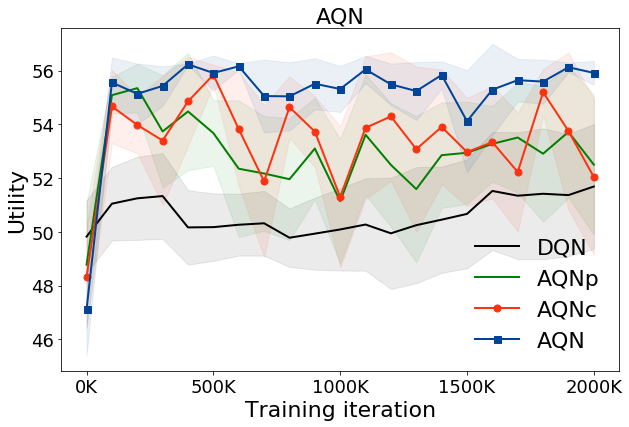

In [8]:
# Figure 2-1: AQN 

final_methods = ['DQN', 'RQN','AQNp120','AQNp060','AQNc2', 'AQNc3', 'AQNc2p030',
                 'TQN','TAQNp30','TAQNp0120','TAQNc2', 'TAQNc3','TAQNc2p030']
final_methods_std = [m +'_std' for m in final_methods]
xdf = xdf2[['iteration']+final_methods + final_methods_std].copy(deep=True)

xdf = xdf.rename(columns={'AQNp120':'AQNp1', 'AQNp120_std':'AQNp1_std', 'AQNp060':'AQNp2','AQNp060_std':'AQNp2_std', 
                         'AQNc2p030':'AQNc2p2', 'AQNc2p030_std':'AQNc2p2_std', 
                          'TAQNp30':'TAQNp1', 'TAQNp30_std':'TAQNp1_std', 'TAQNp0120':'TAQNp2',
                          'TAQNp0120_std':'TAQNp2_std', 'TAQNc2p030':'TAQNc2p2', 'TAQNc2p030_std':'TAQNc2p2_std'
                         })

# Set graphs
MAX_PLOT = 2000000
timefeat = 'iteration'
lineW = [2]*10
logScale = False 
MAX_PLOT = 200
legendYes = False
plotLoc = 'lower left'
markevery, markersize = 1, 5
labelSize, tickSize= 22, 18
figsize = (6,5)
legendPos =  False

final_methods2 = ['DQN', 'RQN', 'AQNp1', 'AQNp2',  'AQNc2', 'AQNc3',  'AQNc2p2',
       'TQN', 'TAQNp1', 'TAQNp2',  'TAQNc2', 'TAQNc3', 'TAQNc2p2']
# Get CI
xdf = getCIall(xdf, final_methods2, repetition=10)

colors = ['black', 'green', '#fc3310','#004499']*3 + ['black']+['#0022ff']*3 
line_style = ['-']*10 
markers = ['', '','o','s'] 

featG = ['DQN', 'AQNp2',  'AQNc2', 'AQNc2p2']
tdf = xdf[['iteration']+ featG + getCIlist(featG)]
col = [tdf.columns[i].replace('2','').replace('cp','') for i in range(len(tdf.columns))]
tdf.columns = col
ytickMin, ytickMax = 0, 58
featG = ['DQN', 'AQNp',  'AQNc', 'AQN']
showAll(tdf, 'AQN', featG, 'AQN', shade=True, legendPos = False, legendSize = 22, ncol = 4, dpi=100)

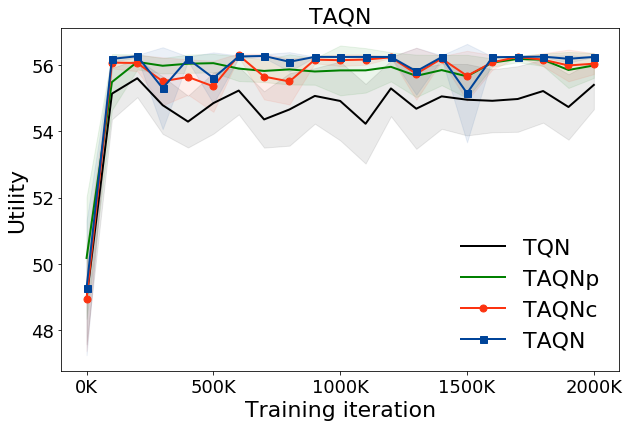

In [9]:
# Figure 2-1: TAQN 

final_methods = ['DQN', 'RQN','AQNp120','AQNp060','AQNc2', 'AQNc3', 'AQNc2p030',
                 'TQN','TAQNp30','TAQNp0120','TAQNc2', 'TAQNc3','TAQNc2p030']
final_methods_std = [m +'_std' for m in final_methods]
xdf = xdf2[['iteration']+final_methods + final_methods_std].copy(deep=True)

xdf = xdf.rename(columns={'AQNp120':'AQNp1', 'AQNp120_std':'AQNp1_std', 'AQNp060':'AQNp2','AQNp060_std':'AQNp2_std', 
                         'AQNc2p030':'AQNc2p2', 'AQNc2p030_std':'AQNc2p2_std', 
                          'TAQNp30':'TAQNp1', 'TAQNp30_std':'TAQNp1_std', 'TAQNp0120':'TAQNp2','TAQNp0120_std':'TAQNp2_std', 
                           'TAQNc2p030':'TAQNc2p2', 'TAQNc2p030_std':'TAQNc2p2_std'
                         })

# Set graphs
MAX_PLOT = 2000000
timefeat = 'iteration'
lineW = [2]*10
logScale = False 
MAX_PLOT = 200
legendYes = False
plotLoc = 'lower left'
markevery, markersize = 1, 5
labelSize, tickSize= 22, 18
figsize = (6,5)
legendPos =  False

final_methods2 = ['DQN', 'AQNp2',  'AQNc2', 'AQNc2p2', 'TQN', 'TAQNp2',  'TAQNc2', 'TAQNc2p2']
# Get CI
xdf = getCIall(xdf, final_methods2, repetition=10)

colors = ['black', 'green', '#fc3310','#004499']*3 + ['black']+['#0022ff']*3 
line_style = ['-']*10 #['-','--', '-']+['-.']*4 
markers = ['', '','o','s'] #,'o', '^','o']

featG = ['TQN', 'TAQNp2',  'TAQNc2', 'TAQNc2p2']
tdf = xdf[['iteration']+ featG + getCIlist(featG)]
col = [tdf.columns[i].replace('2','').replace('cp','') for i in range(len(tdf.columns))]
tdf.columns = col
featG = ['TQN', 'TAQNp',  'TAQNc', 'TAQN']

ytickMin, ytickMax = 0, 58
showAll(tdf, 'TAQN', featG, 'TAQN', shade=True, legendPos = False, legendSize = 22, ncol = 4, dpi=100)